### 基本情况
- JV OpenAPI使得插件开发比较容易
- 墨迹被指定官方插件。如果我们的插件也可以成为官方插件，至少可以增加知名度，而不是让墨迹独大。墨迹目前大概1万6左右使用者，每个月调用量接近1百万次（免费的）
- JV 可以通过与墨迹在不同市场的竞争，阻止他们扩张
- 尽早占据AI相关市场。
- 插件的基本逻辑是：
    - 通过经纬度或者地址查询（location API)来获取我们唯一的location key
    - 通过找到的location key来查询所有天气相关的数据

### 1. 在coze环境内选择生成插件

### 2. 插件工具 

### 2.1： 经纬度到location key

- #### 元数据配置
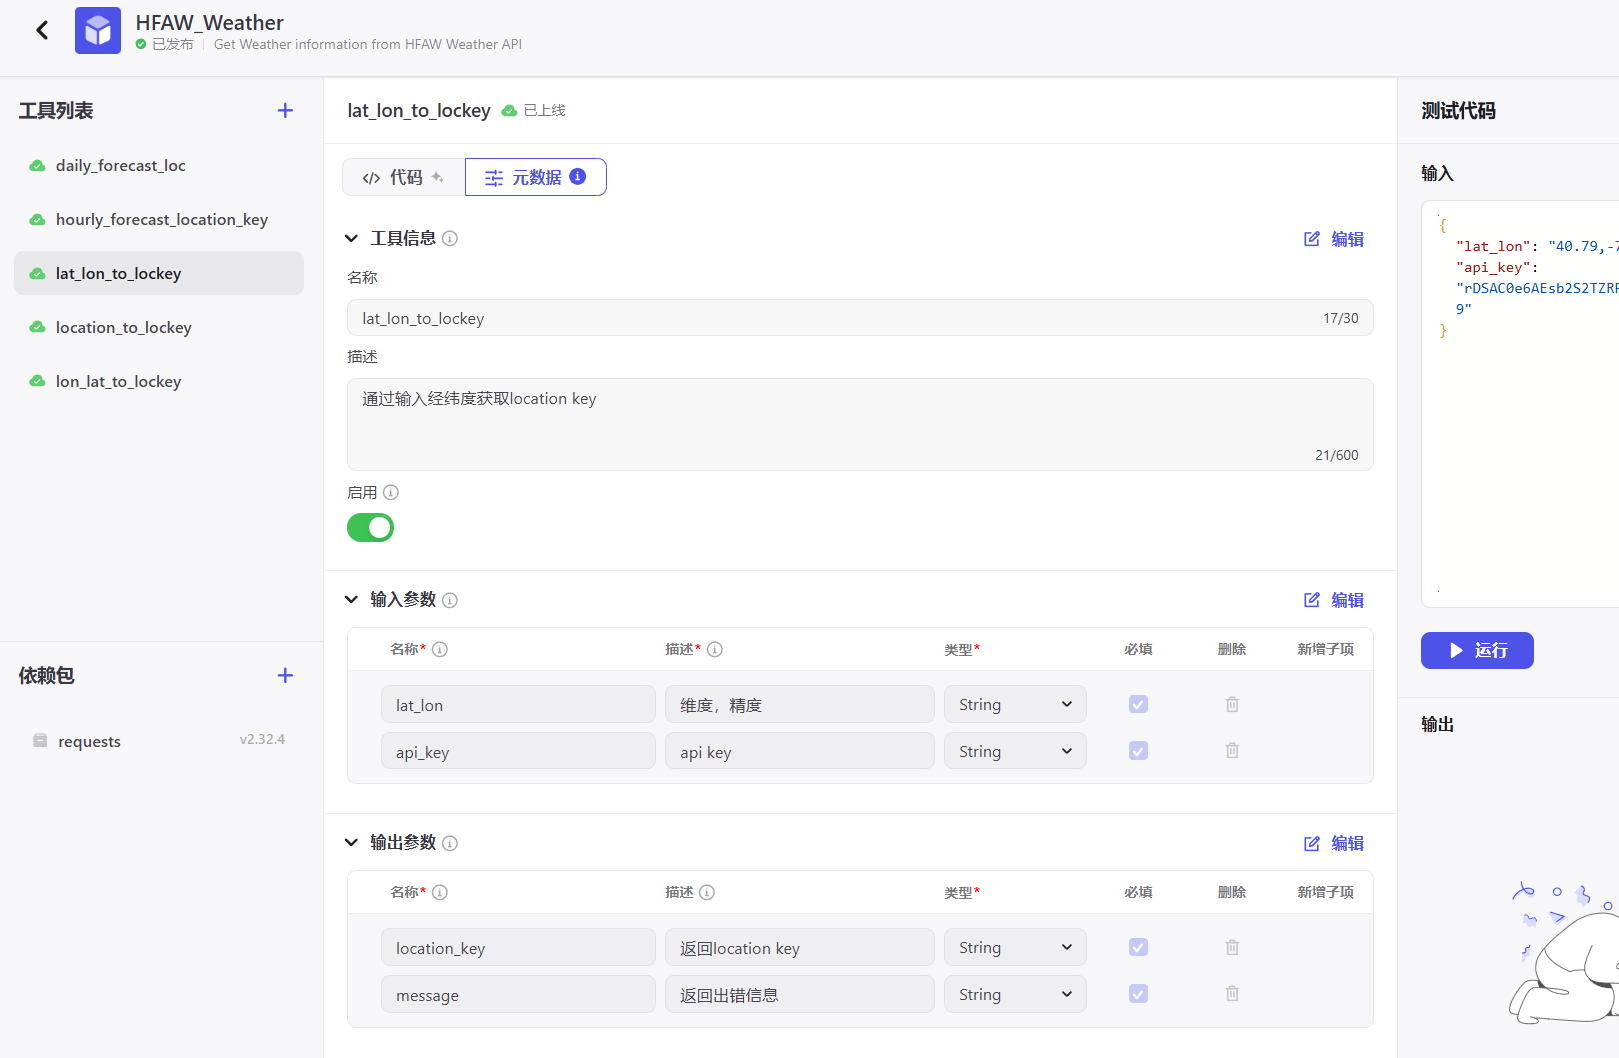

- #### Python 程序

In [ ]:
from runtime import Args
from typings.lat_lon_to_lockey.lat_lon_to_lockey import Input, Output
import requests

"""
Each file needs to export a function named `handler`. This function is the entrance to the Tool.

Parameters:
args: parameters of the entry function.
args.input - input parameters, you can get test input value by args.input.xxx.
args.logger - logger instance used to print logs, injected by runtime.

Remember to fill in input/output in Metadata, it helps LLM to recognize and use tool.

Return:
The return data of the function, which should match the declared output parameters.
"""
def handler(args: Args[Input])->Output:
    try:
        latlon = args.input.lat_lon
        api_key = args.input.api_key
        args.logger.info(f"===== 开始处理地点：{latlon} =====")
        args.logger.warning(f"使用的API Key：{api_key[:4]}****")  # 隐藏部分密钥，避免泄露
        
        # 获取 location_key
        location_url = f"https://openapi.weathercn.com/locations/v1/cities/geoposition/search.json"
        location_params = {
            'apikey': api_key,
            'q': latlon,
            'language':'en-us',
            'details': 'true',
        }

        location_response = requests.get(location_url, params=location_params)
        location_response.raise_for_status()
        location_data = location_response.json()
        args.logger.info(f"===== {location_data} =====")
        if not location_data:
            return {"message": "未找到对应地点"}
        location_key = location_data['Key']
        return {"location_key": str(location_key)}
    except requests.RequestException as e:
        return {"message": f"请求出错: {str(e)}"}
    except Exception as e:
        return {
            "message": f"发生错误: {str(e)}"  
        }
    

-----
### 2.2 地点到location key

- #### 元数据配置
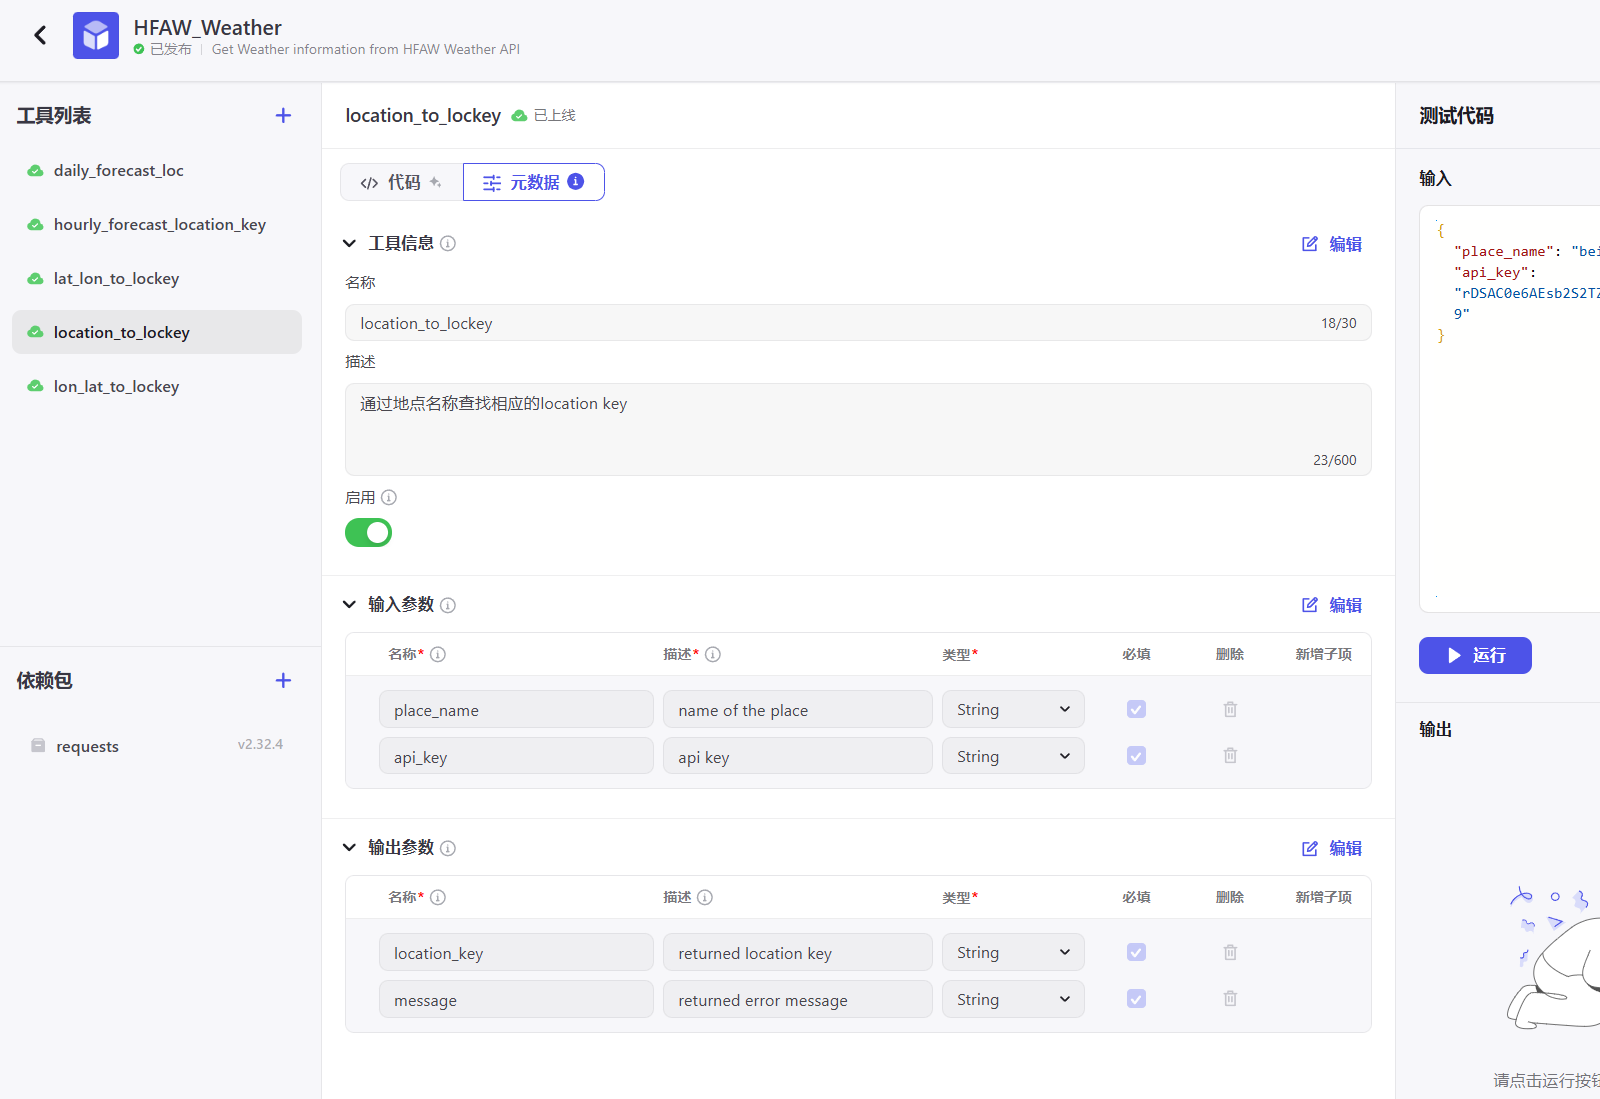

- #### Python

In [ ]:
from runtime import Args
from typings.location_to_lockey.location_to_lockey import Input, Output
import requests
"""
Each file needs to export a function named `handler`. This function is the entrance to the Tool.

Parameters:
args: parameters of the entry function.
args.input - input parameters, you can get test input value by args.input.xxx.
args.logger - logger instance used to print logs, injected by runtime.

Remember to fill in input/output in Metadata, it helps LLM to recognize and use tool.

Return:
The return data of the function, which should match the declared output parameters.
"""
def handler(args: Args[Input])->Output:
    try:
        place_name = args.input.place_name
        api_key = args.input.api_key
        args.logger.info(f"===== 开始处理地点：{place_name} =====")
        args.logger.warning(f"使用的API Key：{api_key[:4]}****")  # 隐藏部分密钥，避免泄露
        
        # 获取 location_key
        location_url = f"https://openapi.weathercn.com/locations/v1/cities/translate"
        location_params = {
            'apikey': api_key,
            'q': place_name
        }
        location_response = requests.get(location_url, params=location_params)

        location_response.raise_for_status()
        location_data = location_response.json()
        if not location_data:
            return {"message": "未找到对应地点"}
        location_key = location_data[0]['Key']
        return {"location_key": str(location_key)}

    except requests.RequestException as e:
        return {"message": f"请求出错: {str(e)}"}
    except Exception as e:
        return {
            "message": f"发生错误: {str(e)}"  
        }

-----
### 2.3 location key获取10天的逐日预报

- #### 元数据配置
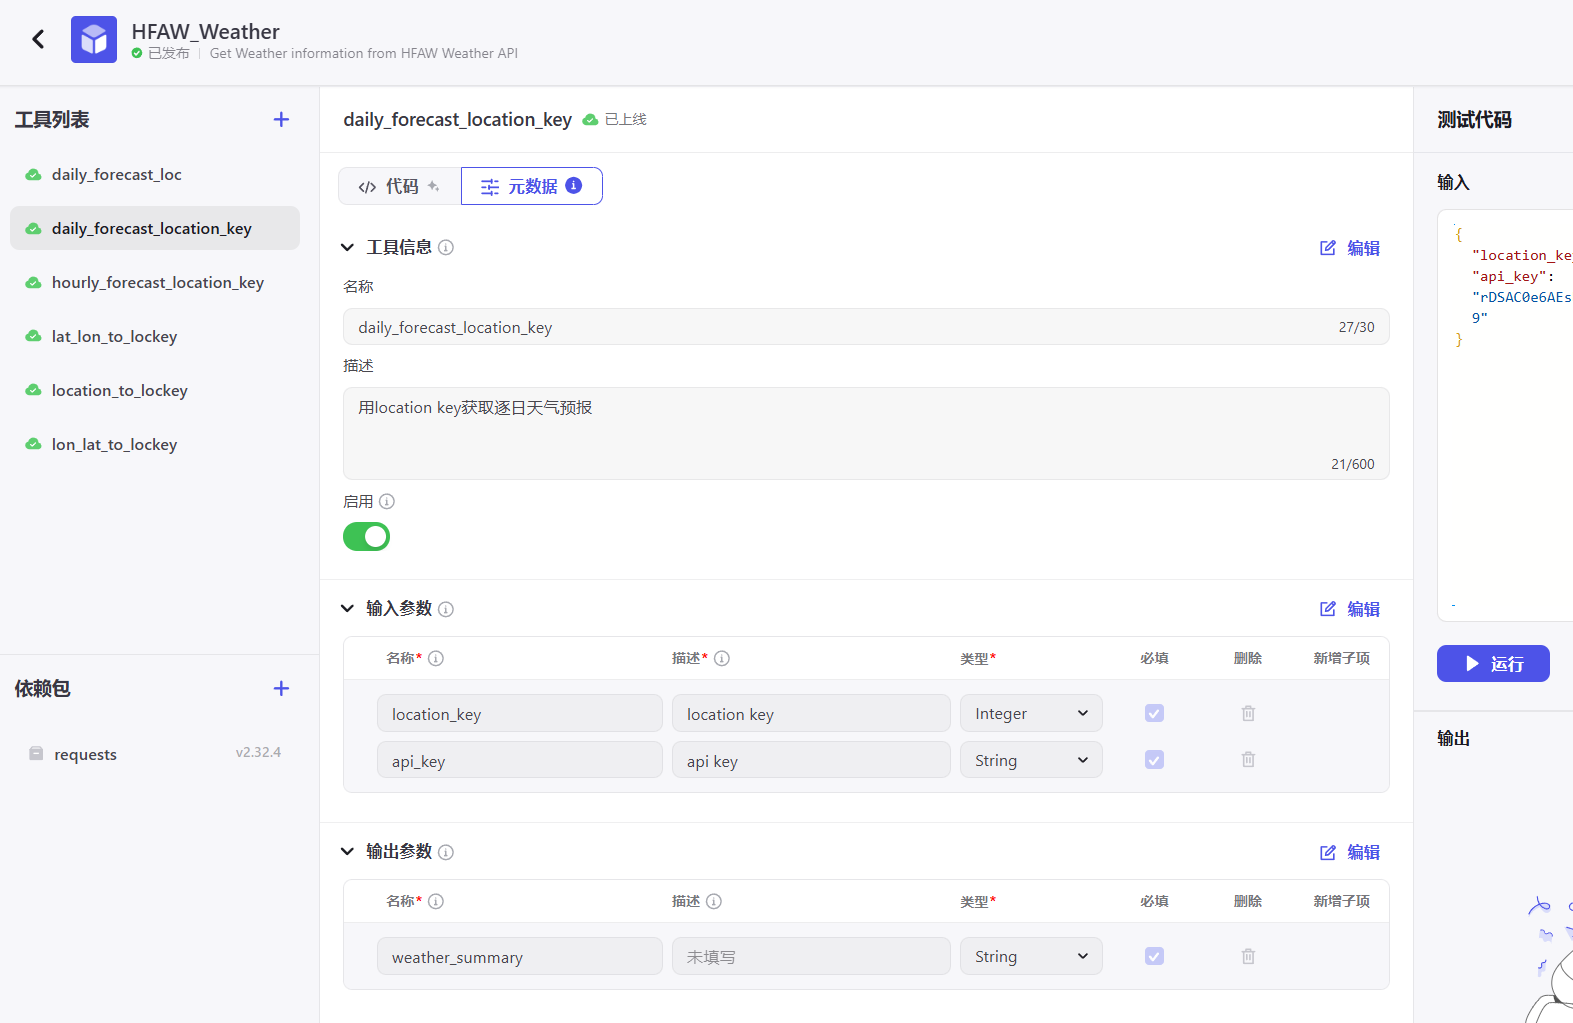

- #### Python

In [ ]:
from runtime import Args
from typings.daily_forecast_location_key.daily_forecast_location_key import Input, Output
import requests
"""
Each file needs to export a function named `handler`. This function is the entrance to the Tool.

Parameters:
args: parameters of the entry function.
args.input - input parameters, you can get test input value by args.input.xxx.
args.logger - logger instance used to print logs, injected by runtime.

Remember to fill in input/output in Metadata, it helps LLM to recognize and use tool.

Return:
The return data of the function, which should match the declared output parameters.
"""
def handler(args: Args[Input])->Output:
    try:
        location_key = args.input.location_key
        api_key = args.input.api_key
        args.logger.info(f"===== 开始处理地点：{location_key} =====")
        args.logger.warning(f"使用的API Key：{api_key[:4]}****")  # 隐藏部分密钥，避免泄露
                
        # 使用 location_key 获取每日预报
        forecast_url = f"https://openapi.weathercn.com/forecasts/v1/daily/10day/{str(location_key)}.JSON"
        forecast_params = {
            'apikey': api_key,
            'language':'en-us',
            'details': 'true',
            'metric' : 'true'
            }
        forecast_response = requests.get(forecast_url, params=forecast_params)
        forecast_response.raise_for_status()
        forecast_data = forecast_response.json()

        args.logger.info(f"location_key：{location_key}") 
        #Summary Data
        ret_data = {
            # 提取头条信息（如高温预警等）
            "headline": {
                "text": forecast_data.get("Headline", {}).get("Text", ""),
                "effective_date": forecast_data.get("Headline", {}).get("EffectiveDate", ""),
                "severity": forecast_data.get("Headline", {}).get("Severity", 0)
            },
            # 提取每日预报（只保留核心字段）
            "daily_forecasts": []
        }

        # 遍历每日预报数据
        for daily in forecast_data.get("DailyForecasts", []):
            # 提取温度信息
            temp = daily.get("Temperature", {})
            min_temp = temp.get("Minimum", {}).get("Value", "")
            max_temp = temp.get("Maximum", {}).get("Value", "")

            rtemp = daily.get("RealFeelTemperature", {})
            min_rtemp = temp.get("Minimum", {}).get("Value", "")
            max_rtemp = temp.get("Maximum", {}).get("Value", "")
            
     
            # dat and night obj
            day_cond = daily.get("Day", {})
            night_cond = daily.get("Night", {})
    
            # day time data
            daily_info = {
                "date": daily.get("Date", ""),  # date
                "temperature": f"{min_temp}~{max_temp} °C",  # temp range
                "real-feel-temperature": f"{min_rtemp}~{max_rtemp} °C",  # temp range
                "day time parameters": {
                    "short-weather-phrase": day_cond.get("ShortPhrase", ""),  # short weather condition
                    "long-weather-phrase": day_cond.get("LongPhrase", ""),  # short weather condition
                    "Probabilities(%)": {
                        "PrecipitationProb": day_cond.get("PrecipitationProbability", 0), 
                        "ThunderstormProb": day_cond.get("ThunderstormProbability", 0), 
                        "RainProb": day_cond.get("RainProbability", 0), 
                        "SnowProb": day_cond.get("SnowProbability", 0), 
                        "IceProb": day_cond.get("IceProbability", 0), 
                    },
                    "wind": 
                        {
                            "speed": f"{day_cond.get('Wind', {}).get('Speed', {}).get('Value', 0)} {day_cond.get('Wind', {}).get('Speed', {}).get('Unit', 'km/h')}"  ,
                            "direction": f"{day_cond.get('Wind', {}).get('Direction', {}).get('Degrees', 0)} {day_cond.get('Wind', {}).get('Direction', {}).get('English', {})}",
                            "gustSpeed": f"{day_cond.get('WindGust', {}).get('Speed', {}).get('Value', 0)} {day_cond.get('Wind', {}).get('Speed', {}).get('Unit', 'km/h')}"  ,
                            "gustDirection": f"{day_cond.get('WindGust', {}).get('Direction', {}).get('Degrees', 0)} {day_cond.get('Wind', {}).get('Direction', {}).get('English', {})}"    
                        },
                    "relativeHumidity":
                        {
                            "min-RelativeHumidity":  day_cond.get("RelativeHumidity", {}).get("Minimum", 0), 
                            "max-RelativeHumidity":  day_cond.get("RelativeHumidity", {}).get("Maximum", 0), 
                            "avg-RelativeHumidity":  day_cond.get("RelativeHumidity", {}).get("Average", 0), 
                        },
                    "total":
                        {
                            "total-liquid": f"{day_cond.get('TotalLiquid', {}).get('Value', 0)} {day_cond.get('TotalLiquid', {}).get('Unit', 0)}",
                            "rain": f"{day_cond.get('Rain', {}).get('Value', 0)} {day_cond.get('Rain', {}).get('Unit', 0)}",
                            "snow": f"{day_cond.get('Snow', {}).get('Value', 0)} {day_cond.get('Snow', {}).get('Unit', 0)}",
                            "ice": f"{day_cond.get('Ice', {}).get('Value', 0)} {day_cond.get('Ice', {}).get('Unit', 0)}"
                        },
                    "cloud-cover(%)": day_cond.get("CloudCover", 0)
                },

                "night time parameters": {
                    "short-weather-phrase": night_cond.get("ShortPhrase", ""),  # short weather condition
                    "long-weather-phrase": night_cond.get("LongPhrase", ""),  # short weather condition
                    "Probabilities(%)": {
                        "PrecipitationProb": night_cond.get("PrecipitationProbability", 0), 
                        "ThunderstormProb": night_cond.get("ThunderstormProbability", 0), 
                        "RainProb": night_cond.get("RainProbability", 0), 
                        "SnowProb": night_cond.get("SnowProbability", 0), 
                        "IceProb": night_cond.get("IceProbability", 0), 
                    },
                    "wind": 
                        {
                            "speed": f"{night_cond.get('Wind', {}).get('Speed', {}).get('Value', 0)} {night_cond.get('Wind', {}).get('Speed', {}).get('Unit', 'km/h')}"  ,
                            "direction": f"{night_cond.get('Wind', {}).get('Direction', {}).get('Degrees', 0)} {night_cond.get('Wind', {}).get('Direction', {}).get('English', {})}",
                            "gustSpeed": f"{night_cond.get('WindGust', {}).get('Speed', {}).get('Value', 0)} {night_cond.get('Wind', {}).get('Speed', {}).get('Unit', 'km/h')}"  ,
                            "gustDirection": f"{night_cond.get('WindGust', {}).get('Direction', {}).get('Degrees', 0)} {night_cond.get('Wind', {}).get('Direction', {}).get('English', {})}"    
                        },
                    "relativeHumidity":
                        {
                            "min-RelativeHumidity":  night_cond.get("RelativeHumidity", {}).get("Minimum", 0), 
                            "max-RelativeHumidity":  night_cond.get("RelativeHumidity", {}).get("Maximum", 0), 
                            "avg-RelativeHumidity":  night_cond.get("RelativeHumidity", {}).get("Average", 0), 
                        },
                    "total":
                        {
                            "total-liquid": f"{night_cond.get('TotalLiquid', {}).get('Value', 0)} {night_cond.get('TotalLiquid', {}).get('Unit', 0)}",
                            "rain": f"{night_cond.get('Rain', {}).get('Value', 0)} {night_cond.get('Rain', {}).get('Unit', 0)}",
                            "snow": f"{night_cond.get('Snow', {}).get('Value', 0)} {night_cond.get('Snow', {}).get('Unit', 0)}",
                            "ice": f"{night_cond.get('Ice', {}).get('Value', 0)} {night_cond.get('Ice', {}).get('Unit', 0)}"
                        },
                    "cloud-cover(%)": night_cond.get("CloudCover", 0)                }
            }
    
            ret_data["daily_forecasts"].append(daily_info)
        return {"weather_summary": str(ret_data)}

    except requests.RequestException as e:
        return {"message": f"请求出错: {str(e)}"}
    except Exception as e:
        return {
            "message": f"发生错误: {str(e)}"  
        }


-----
### 2.4 location key获取逐小时预报

- #### 元数据配置
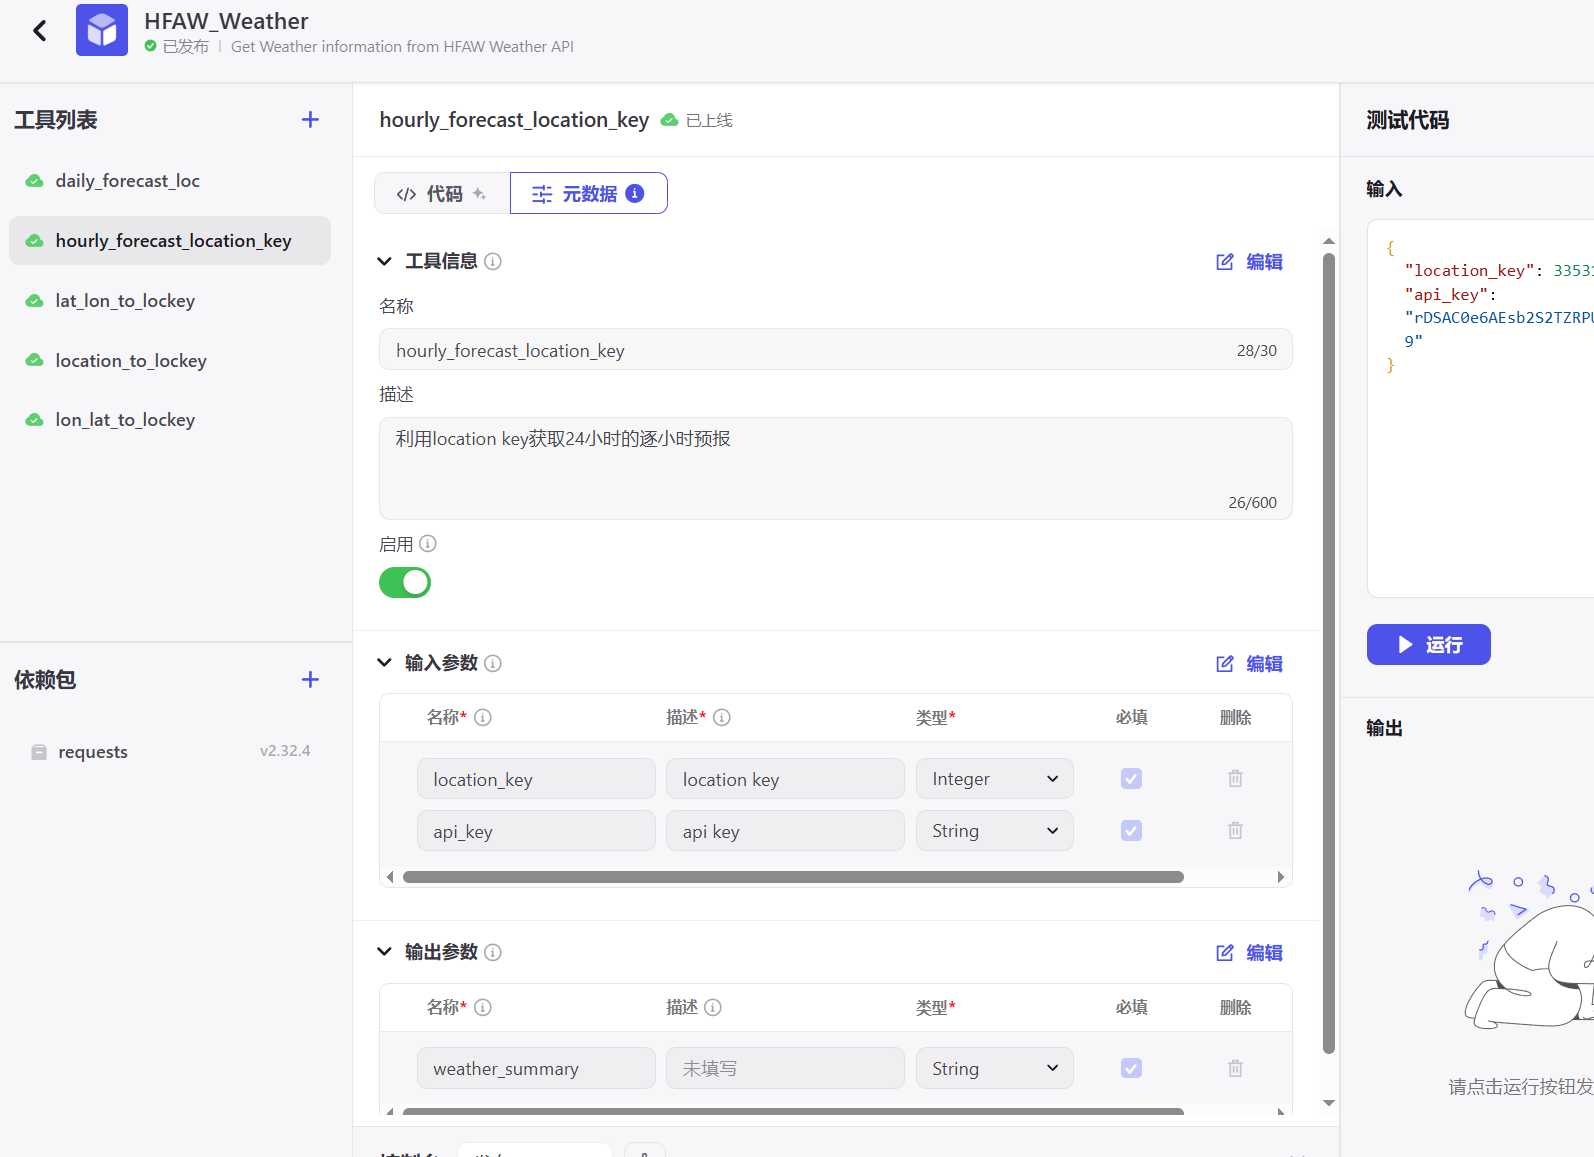

- #### Python

In [ ]:
from runtime import Args
from typings.hourly_forecast_location_key.hourly_forecast_location_key import Input, Output
import requests
"""
Each file needs to export a function named `handler`. This function is the entrance to the Tool.

Parameters:
args: parameters of the entry function.
args.input - input parameters, you can get test input value by args.input.xxx.
args.logger - logger instance used to print logs, injected by runtime.

Remember to fill in input/output in Metadata, it helps LLM to recognize and use tool.

Return:
The return data of the function, which should match the declared output parameters.
"""
def handler(args: Args[Input])->Output:
    if 1==1:
        loc_key = args.input.location_key
        api_key = args.input.api_key
        args.logger.info(f"===== loc_key：{loc_key} =====")
        args.logger.warning(f"使用的API Key：{api_key[:4]}****")  # 隐藏部分密钥，避免泄露
        
        # 使用 location_key 获取每日预报
        forecast_url = f"https://openapi.weathercn.com/forecasts/v1/hourly/24hour/{str(loc_key)}.JSON"
        forecast_params = {
            'apikey': api_key,
            'language':'en-us',
            'details': 'true',
            'metric' : 'true'
            }
        forecast_response = requests.get(forecast_url, params=forecast_params)
        forecast_response.raise_for_status()
        forecast_data = forecast_response.json()

        ret_data = {
            "hourly_forecasts": []
        }

        for hourly in forecast_data:
            # 提取温度信息
            wind = hourly.get("Wind", {})
            windgust = hourly.get("WindGust", {})
            

            hourly_info = {
                "date": hourly.get("DateTime", ""),
                "ShortPhrase": hourly.get("IconPhrase", ""),
                "Temperature": f"{hourly.get('Temperature', {}).get('Value','')} °{hourly.get('Temperature', {}).get('Unit','')}",
                "RealFeelTemperature": f"{hourly.get('RealFeelTemperature', {}).get('Value','')} °{hourly.get('RealFeelTemperature', {}).get('Unit','')}, (Phrase:{hourly.get('RealFeelTemperature', {}).get('Phrase','')})",
                "DewPoint": f"{hourly.get('DewPoint', {}).get('Value','')} °{hourly.get('DewPoint', {}).get('Unit','')}",
                "WindSpeed" : f"{wind.get('Speed', {}).get('Value','')} {wind.get('Speed', {}).get('Unit','')}",
                "WinDirection": f"{wind.get('Direction', {}).get('Degrees','')} ({wind.get('Direction', {}).get('English','')})", 
                "WindGust": f"{windgust.get('Speed', {}).get('Value','')} {windgust.get('Speed', {}).get('Unit','')}",
                "RelativeHumidity": f"{hourly.get('RelativeHumidity', 0)}%",
                "Visibility": f"{hourly.get('Visibility', {}).get('Value','')} {hourly.get('Visibility', {}).get('Unit','')}",
                "PrecipitationProbability": f"{hourly.get('PrecipitationProbability', {})}%",
                "ThunderstormProbability": f"{hourly.get('ThunderstormProbability', {})}%",
                "RainProbability": f"{hourly.get('RainProbability', {})}%",
                "SnowProbability": f"{hourly.get('SnowProbability', {})}%",
                "IceProbability": f"{hourly.get('IceProbability', {})}%",
                "TotalLiquid": f"{hourly.get('TotalLiquid', {}).get('Value','')} {hourly.get('TotalLiquid', {}).get('Unit','')}",
                "Rain": f"{hourly.get('Rain', {}).get('Value','')} {hourly.get('Rain', {}).get('Unit','')}",
                "Snow": f"{hourly.get('Snow', {}).get('Value','')} {hourly.get('Snow', {}).get('Unit','')}",
                "Ice": f"{hourly.get('Ice', {}).get('Value','')} {hourly.get('Ice', {}).get('Unit','')}",
                "CloudCover": f"{hourly.get('CloudCover', {})}%"
            }
            ret_data["hourly_forecasts"].append(hourly_info)

        return {"weather_summary": str(ret_data)}


### 3. 测试插件

#### 3.1 使用JV天气插件的工作流
- 为给定地址或名称（比如北京四中）给出未来10天的天气总结
    - 使用高德插件将POI转换成经纬度
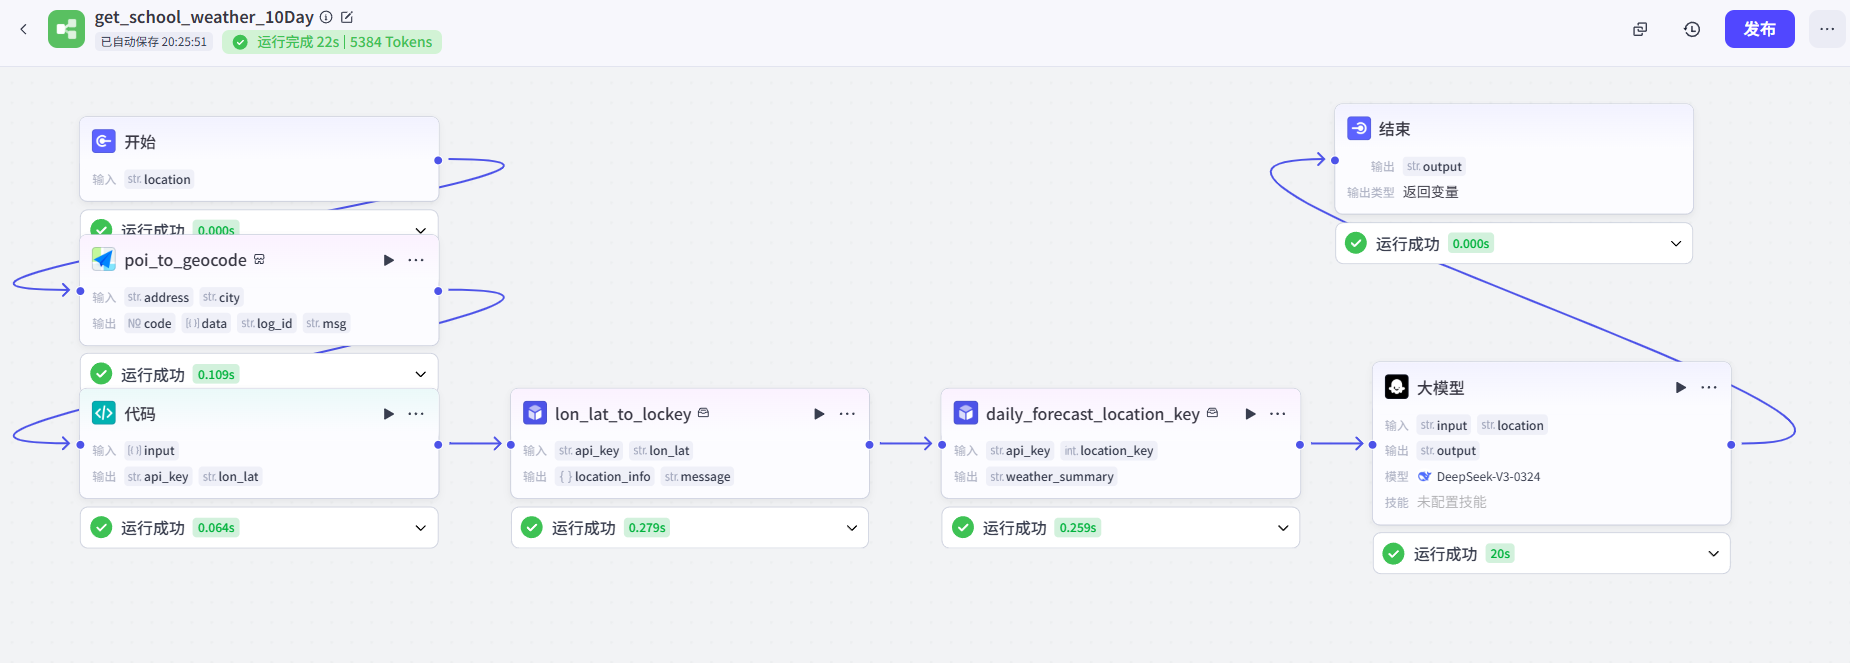

#### 3.2 输入输出
- 输入：广东省广州市天河体育中心
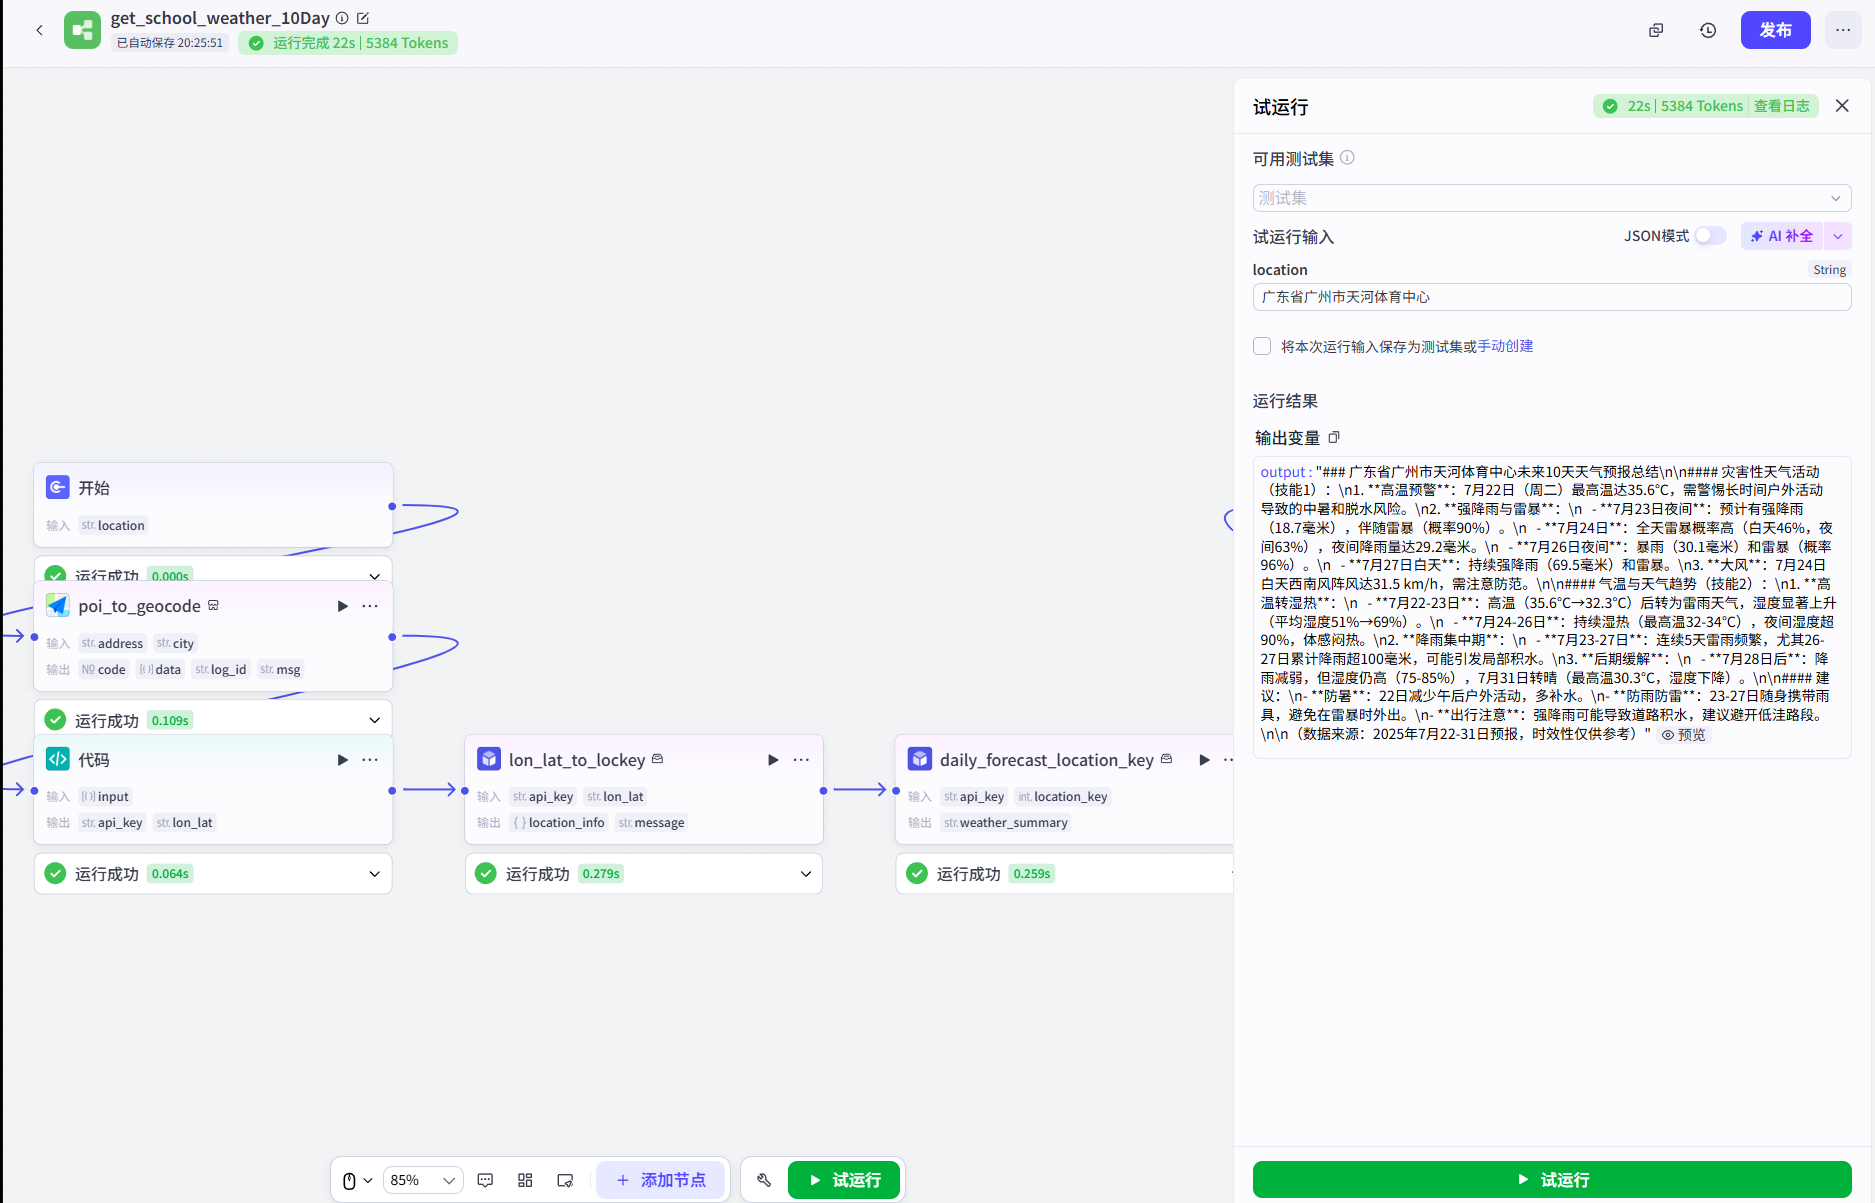

- 输出结果预览
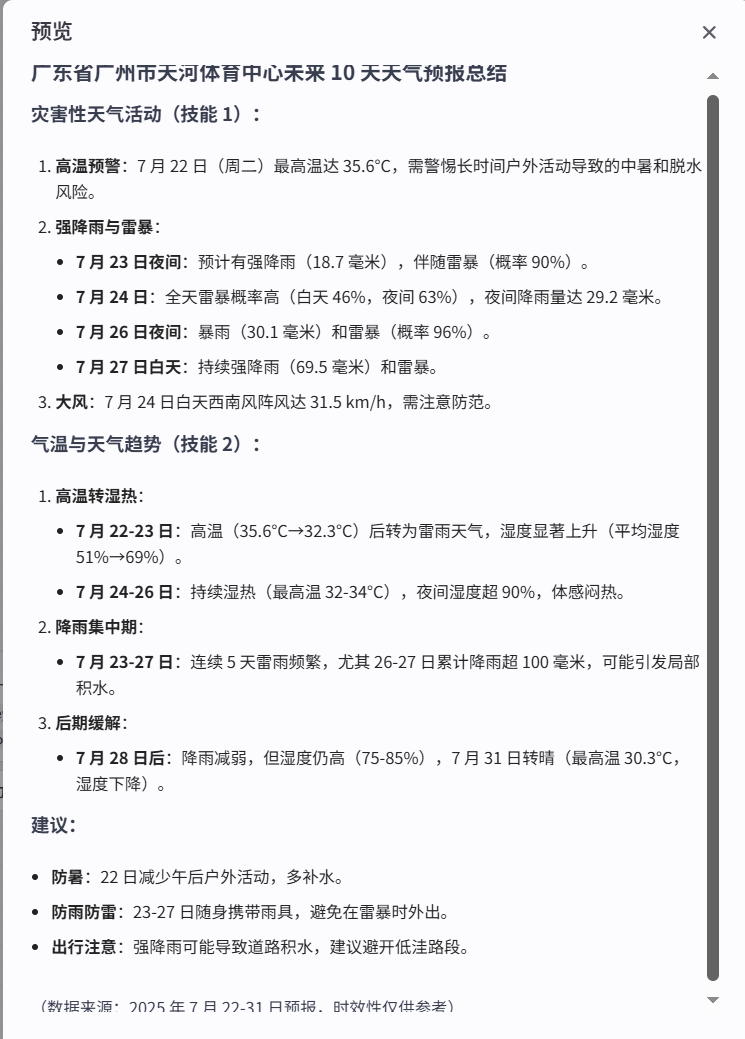

### 4. 插件输出探讨
- 正常的插件可以只提供原始天气数据。
- 特别准备的天气数据（可以在插件里处理，或者在API上作特别处理），方便不同领域人的分析。
    - 比如目前降水量最大的50个地点
    - 全国前50的污染城市
    - 全国气温超过40度的城市
    - 历史上某个城市的最高，最低气温

### 5. 演示工作流
- 可以复制json文件，然后粘贴到coze的工作流桌面就可以得到工作流。

#### 5.1 逐小时预报演示

#### 5.2 中文逐日预报总结

#### 5.3 简单的中文测试